In [ ]:
#!pip install pandas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#!pip install sklearn
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.decomposition import PCA
# to ignore user warnings given from many jobs being taken on by the processor
import warnings
warnings.filterwarnings("ignore")

In [ ]:
train1 = pd.read_csv('Education/FML/training1.csv').values
preds_conf1 = train1[:, 4608:]
print('predictions and confidences 1 has shape', preds_conf1.shape)
train1 = train1[:, :4608]
print('train data 1 has shape', train1.shape)
train2 = pd.read_csv('Education/FML/training2.csv').values
preds_conf2 = train2[:, 4608:]
print('predictions and confidences 2 has shape', preds_conf2.shape)
train2 = train2[:, :4608]
print('train data 2 has shape', train2.shape)
test = pd.read_csv('Education/FML/test.csv').values
print('test data has shape', test.shape)
sample_valid_preds = pd.read_csv('Education/FML/sample_valid_predictions.csv').values
print('sample predictions has shape', sample_valid_preds.shape)

In [ ]:
miss = np.isnan(train2[:]).sum()
plt.bar(range(2800), miss, width=1.0)
plt.xlabel('Training Set 2 Sample Index')
plt.ylabel('Number of Missing Features')
plt.title('Number of Missing Features per Sample')
plt.show()

In [ ]:
def full_model(feat='all', train1_only=False, train2_only=False, n_estimators_rfc=500, max_features_rfc='sqrt', 
               normalize=False, standardise=False, pca=False, discard_conf=False):
    if feat == 'all':
        if train1_only == True:
            X = train1
        elif train2_only == True:
            X = train2
        else:
            X = np.concatenate((train1, train2))
    elif feat == 'cnn':
        X = np.concatenate((train1[:, :4096], train2[:, :4096]))
    elif feat == 'gist':
        X = np.concatenate((train1[:, 4096:], train2[:, 4096:]))
    if discard_conf == True:
        if train1_only == True:
            y = preds_conf1
        elif train2_only == True:
            y = preds_conf2
        else:
            y = np.concatenate((preds_conf1, preds_conf2))
        clean_X = []
        clean_y = []
        for i in range(len(y)):
            if y[i][1] == 1.0:
                clean_X.append(X[i])
                clean_y.append(y[i][0])
        X = clean_X
        y = clean_y
    else:
        if train1_only == True:
            y = preds_conf1[:, 0]
        elif train2_only == True:
            y = preds_conf2[:, 0]
        else:
            y = np.concatenate((preds_conf1[:, 0], preds_conf2[:, 0]))
    model = RandomForestClassifier(n_estimators=n_estimators_rfc, 
                                   max_features=max_features_rfc)
    imputer = KNNImputer()
    if normalize == True:
        pipeline = Pipeline(steps=[('i', imputer), ('n', preprocessing.Normalizer()), 
                                   ('m', model)])
    elif standardise == True:
        pipeline = Pipeline(steps=[('i', imputer), ('s', preprocessing.StandardScaler()), 
                                   ('m', model)])
    elif pca == True:
        pipeline = Pipeline(steps=[('i', imputer), ('s', preprocessing.StandardScaler()), 
                                   ('p', PCA(n_components=1)), ('m', model)])
    else:
        pipeline = Pipeline(steps=[('i', imputer), ('m', model)])
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, 
                             n_jobs=-1, error_score='raise')
    print(f'Mean Accuracy: {np.mean(scores)}, Standard Devaition: {np.std(scores)}')
    return scores

In [ ]:
# change hyperparameters of random forest and check performance
max_acc = 0
best_param = [0, 0]
max_features_to_try = ['sqrt', 'log2']
num_estimators_to_try = [10, 50, 100, 200]
for n_estimators in num_estimators_to_try:
    for max_features in max_features_to_try:
        full_model(n_estimators_rfc=n_estimators, max_features_rfc=max_features)

Mean Accuracy: 0.7054901960784313, Standard Devaition: 0.02329210395996824
Mean Accuracy: 0.6916666666666667, Standard Devaition: 0.020964122333669708
Mean Accuracy: 0.7442156862745098, Standard Devaition: 0.021174881930242438
Mean Accuracy: 0.7432352941176472, Standard Devaition: 0.020548280558480667
Mean Accuracy: 0.7474509803921568, Standard Devaition: 0.020779688719597133
Mean Accuracy: 0.7425490196078434, Standard Devaition: 0.021716073559154413
Mean Accuracy: 0.75, Standard Devaition: 0.02186516297190062
Mean Accuracy: 0.7472549019607844, Standard Devaition: 0.023344041042859063


In [ ]:
# trying out more values for n_estimators
num_estimators_to_try = [300, 400, 500, 1000, 1500]
for n_estimators in num_estimators_to_try:
    full_model(n_estimators_rfc=n_estimators)

Mean Accuracy: 0.7508823529411763, Standard Devaition: 0.022822089099489823
Mean Accuracy: 0.7513725490196079, Standard Devaition: 0.02077968871959714
Mean Accuracy: 0.7530392156862743, Standard Devaition: 0.020622986544387694
Mean Accuracy: 0.7529411764705884, Standard Devaition: 0.021639811233445317
Mean Accuracy: 0.7520588235294118, Standard Devaition: 0.02093751344918571


In [ ]:
def sort_and_visualise(num_estimators, num_estimators_accs, num_estimators_stds):
    num_estimators_accs_sorted, num_estimators_stds_sorted, num_estimators_sorted = (
    list(t) for t in zip(*sorted(zip(num_estimators_accs, num_estimators_stds, 
                                     num_estimators), reverse=True))
        )
    print(num_estimators_sorted)
    print(num_estimators_accs_sorted)
    print(num_estimators_stds_sorted, '\n')
    plt.bar([str(n) for n in num_estimators], num_estimators_accs, 
            yerr=num_estimators_stds, ecolor="r")
    plt.xlabel('Number of Estimators')
    plt.ylabel('Mean Accuracy')
    plt.title('Mean Accuracy using Diffrent Numbers of Estimators')
    plt.show()

[500, 1000, 1500, 400, 300, 200, 100, 50, 10]
[75.304, 75.294, 75.206, 75.137, 75.088, 75.0, 74.745, 74.422, 70.549]
[2.062, 2.164, 2.094, 2.078, 2.282, 2.187, 2.078, 2.117, 2.329] 



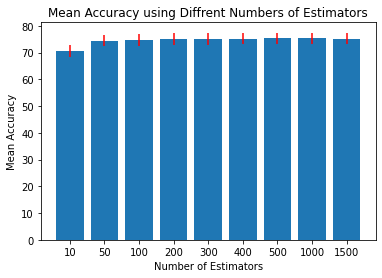

In [ ]:
num_estimators = np.array([10, 50, 100, 200, 300, 400, 500, 1000, 1500])
num_estimators_accs = np.array([70.549, 74.422, 74.745, 75.000, 75.088, 75.137, 
                                75.304, 75.294, 75.206])
num_estimators_stds = np.array([2.329, 2.117, 2.078, 2.187, 2.282, 2.078, 
                                2.062, 2.164, 2.094])

sort_and_visualise(num_estimators, num_estimators_accs, num_estimators_stds)

In [ ]:
# using all features
all_feat_scores = full_model()

Mean Accuracy: 0.7524509803921567, Standard Devaition: 0.022245398333596473


In [ ]:
# using training set 1 only
train1_only_scores = full_model(train1_only=True)

Mean Accuracy: 0.7727777777777778, Standard Devaition: 0.04820545023230015


In [ ]:
# using training set 2 only
train2_only_scores = full_model(train2_only=True)

Mean Accuracy: 0.7392857142857143, Standard Devaition: 0.017003401020340123


In [ ]:
# using cnn features only
cnn_feat_scores = full_model(feat='cnn')

Mean Accuracy: 0.7433333333333333, Standard Devaition: 0.020629277485673864


In [ ]:
# using gist features only
gist_feat_scores = full_model(feat='gist')

Mean Accuracy: 0.6820588235294117, Standard Devaition: 0.027615229905290122


In [ ]:
# data normalization after imputing with all features
normalized_scores = full_model(normalize=True)

Mean Accuracy: 0.7496078431372549, Standard Devaition: 0.019564658326692422


In [ ]:
# data standardization after imputing with all features
standardised_scores = full_model(standardise=True)

Mean Accuracy: 0.752549019607843, Standard Devaition: 0.020821276788169855


In [ ]:
# using pca after imputing and scaling to reduce the dimensions of the data
pca_scores = full_model(pca=True)

Mean Accuracy: 0.5955882352941176, Standard Devaition: 0.022408985469176985


In [ ]:
# discarding samples with a onfidence label 0f 0.66
discarded_conf_scores = full_model(discard_conf=True)

Mean Accuracy: 0.7842030794839784, Standard Devaition: 0.03961235926147556


In [ ]:
# testing diffrent num_estimators with data with confidences labels of 0.66 discarded
num_estimators_to_try = [10, 50, 100, 200, 300, 400, 500, 1000, 1500]
for n_estimators in num_estimators_to_try:
    full_model(n_estimators_rfc=n_estimators, discard_conf=True)

Mean Accuracy: 0.7452725759467334, Standard Devaition: 0.045500237248816806
Mean Accuracy: 0.777149396587599, Standard Devaition: 0.037848523595093816
Mean Accuracy: 0.7815980024968788, Standard Devaition: 0.042364643236133114
Mean Accuracy: 0.7834748231377446, Standard Devaition: 0.03629982325504416
Mean Accuracy: 0.787544735746983, Standard Devaition: 0.03596860271195215
Mean Accuracy: 0.7845609654598417, Standard Devaition: 0.035748213431447226
Mean Accuracy: 0.7849438202247191, Standard Devaition: 0.03875105376967621
Mean Accuracy: 0.7827174365376612, Standard Devaition: 0.037508887461087846
Mean Accuracy: 0.7842030794839784, Standard Devaition: 0.03961470685642236


[300, 500, 400, 1500, 200, 1000, 100, 50, 10]
[78.754, 78.494, 78.456, 78.42, 78.347, 78.271, 78.16, 77.715, 74.527]
[3.597, 3.875, 3.575, 3.961, 3.63, 3.751, 4.236, 3.785, 4.55] 



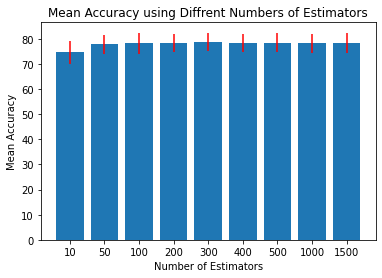

In [ ]:
num_estimators = np.array([10, 50, 100, 200, 300, 400, 500, 1000, 1500])
num_estimators_accs = np.array([74.527, 77.715, 78.160, 78.347, 78.754, 78.456, 
                                78.494, 78.271, 78.420])
num_estimators_stds = np.array([4.550, 3.785, 4.236, 3.630, 3.597, 3.575, 3.875, 
                                3.751, 3.961])

sort_and_visualise(num_estimators, num_estimators_accs, num_estimators_stds)

In [ ]:
# combining using training set 1 only with discarding samples with a confidence label 0f 0.66
discarded_conf_train1_only_scores = full_model(discard_conf=True, train1_only=True)

168
Mean Accuracy: 0.8968137254901961, Standard Devaition: 0.06075960123830183


In [ ]:
# combining using training set 2 only with discarding samples with a confidence label 0f 0.66
discarded_conf_train2_only_scores = full_model(discard_conf=True, train2_only=True)

Mean Accuracy: 0.7428174750092558, Standard Devaition: 0.0440558157304398


In [ ]:
# test set predictions
X = np.concatenate((train1, train2))
y = np.concatenate((preds_conf1, preds_conf2))
clean_X = []
clean_y = []
for i in range(len(y)):
    if y[i][1] == 1.0:
        clean_X.append(X[i])
        clean_y.append(y[i][0])
X = clean_X
y = clean_y
model = RandomForestClassifier(n_estimators=500, max_features='sqrt')
imputer = KNNImputer()
pipeline = Pipeline(steps=[('i', imputer), ('m', model)])
pipeline.fit(X, y)
test_preds = list(pipeline.predict(test))
test_preds = [str(int(pred)) for pred in test_preds]
test_preds.insert(0, "prediction")
print(test_preds)

['prediction', '0', '1', '1', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '1', '1', '0', '1', '1', '0', '0', '1', '0', '1', '1', '1', '0', '0', '1', '0', '0', '1', '1', '0', '0', '1', '1', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '1', '0', '1', '1', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0', '1', '1', '0', '1', '0', '1', '1', '1', '1', '0', '0', '0', '0', '0', '1', '0', '1', '1', '0', '1', '0', '0', '0', '1', '1', '0', '1', '1', '1', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '1', '1', '1', '1', '0', '1', '1', '0', '1', '1', '1', '1', '1', '0', '0', '1', '1', '1', '1', '1', '0', '1', '0', '0', '0', '1', '0', '0', '1', '1', '0', '1', '0', '0', '1', '0', '1', '0', '1', '1', '1', '1', '1', '1', '1', '0', '0', '1', '0', '1', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '0', '1', '0', '1', '1', '1', '1', '0', '1', '1', '0', '1', '1', '0', '1', '1', '0', '0', '1', '1', '1', '0', '0', '0', '1', '1', 

In [ ]:
np.savetxt("Education/FML/test_predictions.csv", test_preds, delimiter=",", fmt='%s')